<a href="https://colab.research.google.com/github/tomiambro/covid_transfer_learning/blob/main/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab
!pip install --upgrade git+https://github.com/fastai/fastai.git &> 2
!pip install pip install nbdev &> 2

# Covid detection using CT Scans

In [2]:
from fastai.vision.all import *
from torchvision import transforms as T

import gc

In [3]:
dataset_path = 'gdrive/MyDrive/machine_learning/datasets/covid_dataset'  #change dir to your project folder
folder_path = 'gdrive/MyDrive/machine_learning/covid/'

In [5]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


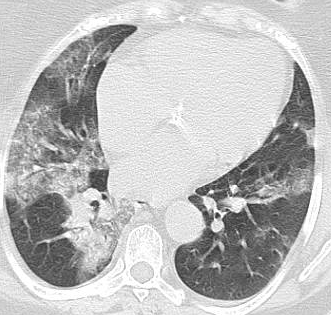

In [6]:
im = Image.open(f"{dataset_path}/COVID/Covid (1000).png")
im.to_thumb(350,350)

Create array with Path objects to imgs

In [7]:
path = Path(f"{dataset_path}")

In [8]:
imgs = get_image_files(f"{dataset_path}")
imgs[:5]

(#5) [Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1227).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1229).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1226).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1209).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1238).png')]

In [9]:
covid = DataBlock(
    blocks=(ImageBlock, CategoryBlock(['non-COVID', 'COVID'], sort=False)), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(350,350))

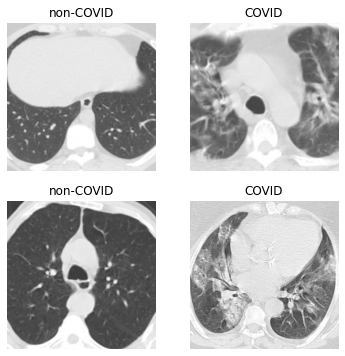

In [10]:
dls = covid.dataloaders(path)
dls.valid.show_batch(max_n=4)

In [11]:
res34 = cnn_learner(dls, resnet34, metrics=[F1Score(), Recall()], path=folder_path)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627

  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [12]:
lr = 1e-3
res34.fine_tune(4, lr, freeze_epochs=2)

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.884014,0.484359,0.787368,0.769547,08:40
1,0.644360,0.357226,0.853933,0.938272,00:24


epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.317241,0.229830,0.910284,0.855967,00:30
1,0.225654,0.122697,0.951374,0.925926,00:30
2,0.135520,0.099608,0.965235,0.971193,00:28
3,0.086666,0.098131,0.957230,0.967078,00:29


In [13]:
df_rec34 = pd.DataFrame(res34.recorder.values, columns=['train_loss', 'valid_loss', 'f1_score', 'recall_score'])

In [14]:
df_rec34

,train_loss,valid_loss,f1_score,recall_score
0,0.317241,0.229830,0.910284,0.855967
1,0.225654,0.122697,0.951374,0.925926
2,0.135520,0.099608,0.965235,0.971193
3,0.086666,0.098131,0.957230,0.967078


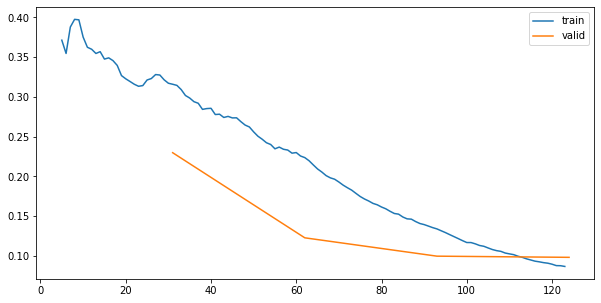

In [15]:
plt.figure(figsize=(10,5))
res34.recorder.plot_loss()

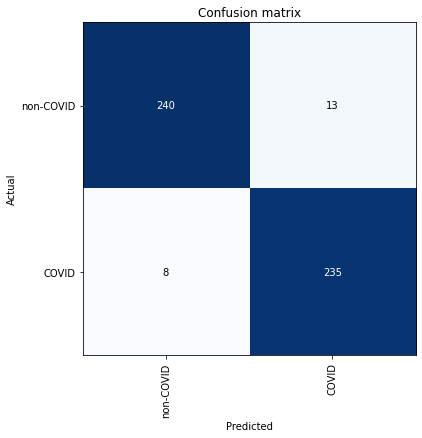

In [16]:
interp = ClassificationInterpretation.from_learner(res34)
interp.plot_confusion_matrix(figsize=(6,6))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


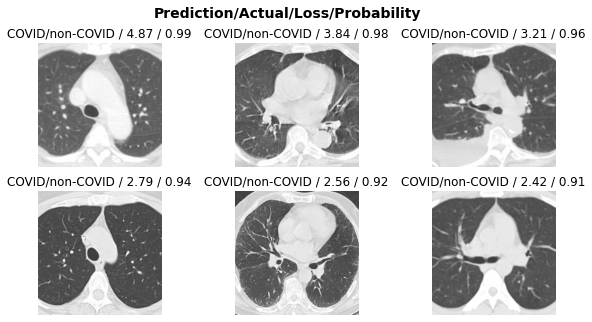

In [17]:
interp.plot_top_losses(6, figsize=(10,5))

In [18]:
res34.predict(f"{dataset_path}/COVID/Covid (1000).png")

('COVID', TensorBase(1), TensorBase([5.6212e-08, 1.0000e+00]))

In [19]:
res34.export('res34.pkl')

In [20]:
covid = covid.new(
    item_tfms=Resize(350,350),
    batch_tfms=[DeterministicFlip, Contrast(p=1, draw=1.50)])
dls = covid.dataloaders(path)

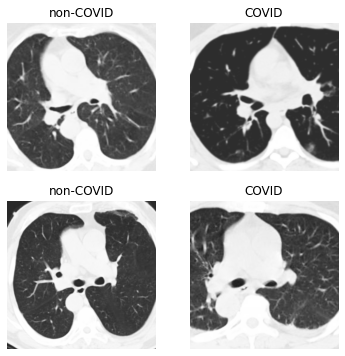

In [21]:
dls.train.show_batch(max_n=4)

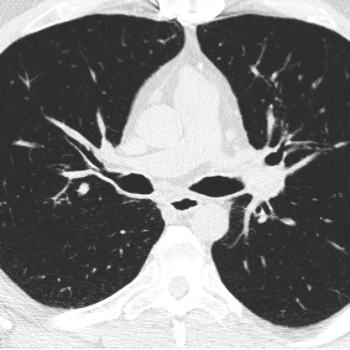

In [22]:
train_features, train_labels = next(iter(dls.train))
trans = T.ToPILImage()
trans(train_features[0])

In [23]:
res34_con = cnn_learner(dls, resnet34, metrics=[F1Score(), Recall()], path=folder_path)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
lr = 1e-3
res34_con.fine_tune(5, lr, freeze_epochs=1)

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.782794,0.598569,0.774306,0.917695,00:25


epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.433159,0.537309,0.808799,0.983539,00:29
1,0.308702,0.242550,0.912281,0.962963,00:30
2,0.208645,0.182468,0.933602,0.954733,00:29
3,0.136748,0.167613,0.937876,0.962963,00:29
4,0.100499,0.186051,0.935167,0.979424,00:29


In [25]:
df_rec34_con = pd.DataFrame(res34_con.recorder.values, columns=['train_loss', 'valid_loss', 'f1_score', 'recall_score'])

In [26]:
df_rec34_con

,train_loss,valid_loss,f1_score,recall_score
0,0.433159,0.537309,0.808799,0.983539
1,0.308702,0.242550,0.912281,0.962963
2,0.208645,0.182468,0.933602,0.954733
3,0.136748,0.167613,0.937876,0.962963
4,0.100499,0.186051,0.935167,0.979424


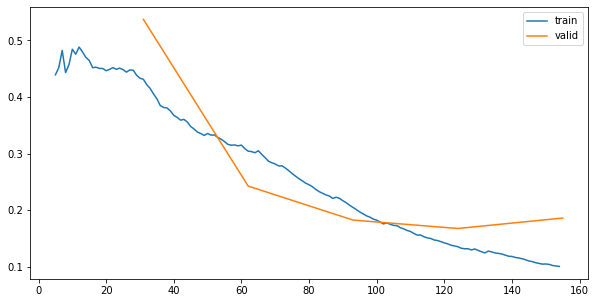

In [27]:
plt.figure(figsize=(10,5))
res34_con.recorder.plot_loss()

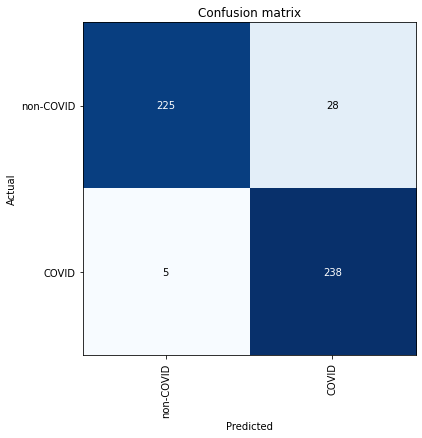

In [28]:
interp = ClassificationInterpretation.from_learner(res34_con)
interp.plot_confusion_matrix(figsize=(6,6))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


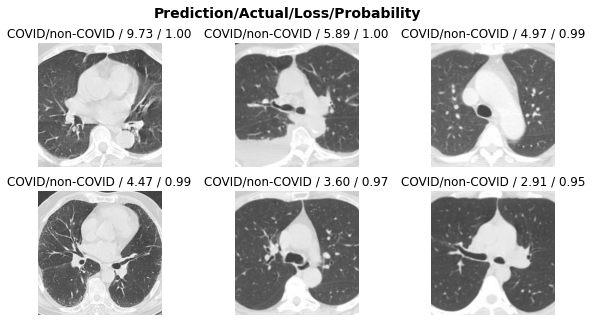

In [29]:
interp.plot_top_losses(6, figsize=(10,5))

In [30]:
res34_con.export('res34_con.pkl')

In [31]:
covid = covid.new(
    item_tfms=Resize(350,350),
    batch_tfms=[DeterministicFlip, RandomErasing(1, min_aspect=0.3, sh=0.1)])
dls = covid.dataloaders(path)

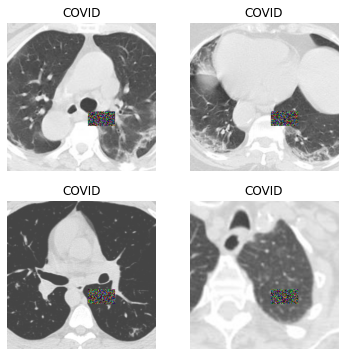

In [32]:
dls.train.show_batch(max_n=4)

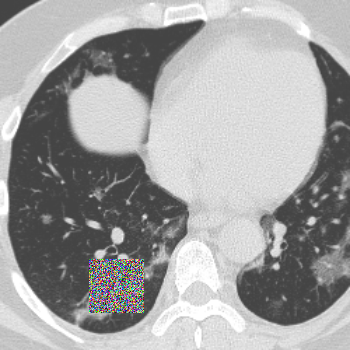

In [33]:
train_features, train_labels = next(iter(dls.train))
trans = T.ToPILImage()
trans(train_features[0])

In [34]:
res34_noise = cnn_learner(dls, resnet34, metrics=[F1Score(), Recall()], path=folder_path)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
lr = 1e-3
res34_noise.fine_tune(6, lr, freeze_epochs=2)

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.951252,0.486603,0.805430,0.732510,00:25
1,0.698460,0.304552,0.879668,0.872428,00:25


epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.431229,0.245440,0.908705,0.880658,00:30
1,0.342854,0.253439,0.904762,0.938272,00:29
2,0.272948,0.164013,0.959488,0.925926,00:29
3,0.200603,0.096106,0.968421,0.946502,00:29
4,0.156474,0.090728,0.972860,0.958848,00:29
5,0.123121,0.086109,0.972973,0.962963,00:29


In [36]:
df_rec34_noise = pd.DataFrame(res34_noise.recorder.values, columns=['train_loss', 'valid_loss', 'f1_score', 'recall_score'])

In [37]:
df_rec34_noise

,train_loss,valid_loss,f1_score,recall_score
0,0.431229,0.245440,0.908705,0.880658
1,0.342854,0.253439,0.904762,0.938272
2,0.272948,0.164013,0.959488,0.925926
3,0.200603,0.096106,0.968421,0.946502
4,0.156474,0.090728,0.972860,0.958848
5,0.123121,0.086109,0.972973,0.962963


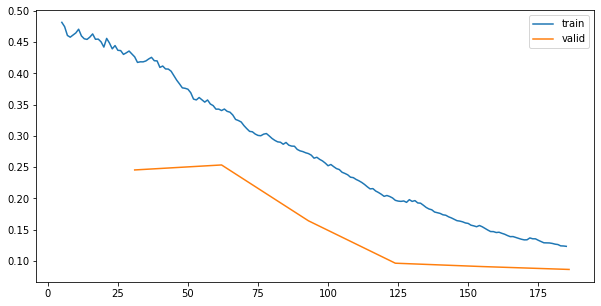

In [38]:
plt.figure(figsize=(10,5))
res34_noise.recorder.plot_loss()

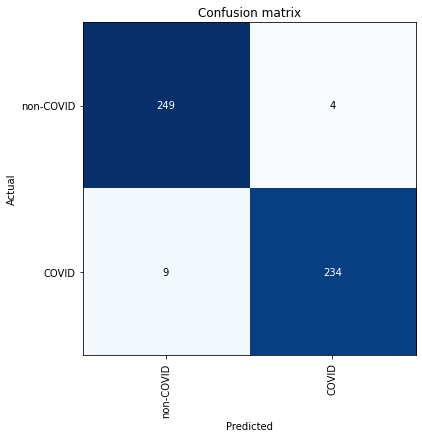

In [39]:
interp = ClassificationInterpretation.from_learner(res34_noise)
interp.plot_confusion_matrix(figsize=(6,6))

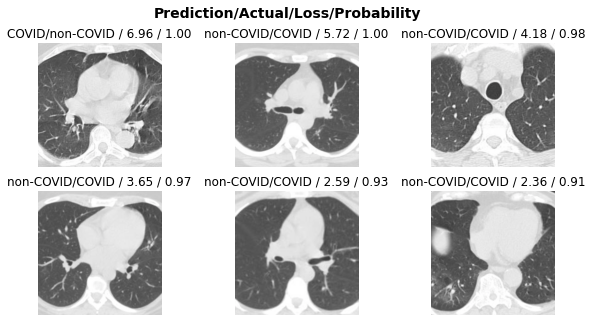

In [40]:
interp.plot_top_losses(6, figsize=(10,5))

In [41]:
res34_noise.export('res34_noise.pkl')

## Inference and Ensembling

In [42]:
class Ensemble:
  def __init__(self, dl, models : dict, vocab : list = [0, 1]):
    self.models = models
    self.vocab = vocab
    self.dl = dl
    print(f'vocab: {self.vocab}')
    for name, model in models.items():
      print(f'loaded: {name}')


  def calc_probas(self, item):
    probas = []
    for _, model in self.models.items():
      _, _, p = model.predict(item)
      probas.append(p)
    
    probas = torch.stack(probas, dim=0)
    return probas

  def predict(self, item):
    probas = self.calc_probas(item)
    mean, std = probas.mean(axis=0), probas.std(axis=0)

    return self.vocab[mean.argmax()], mean, std
  
  def get_preds(self, dl=None, with_input=True, with_loss=True, with_decoded=True, act=None):
    if dl is None: dl = self.model_list[0].dls[1]
    predictions = []
    losses = []
    for name, model in self.models.items():
      print(f'Getting predictions from {name}')
      inputs, preds, targs, decoded, loss = model.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None)
      predictions.append(preds)
      losses.append(loss)
    
    print()
    preds = torch.stack(predictions).mean(0)
    decoded = preds.argmax(1)
    return inputs, preds, targs, decoded, torch.stack(losses, dim=1).mean(1)

  def calc_metrics(self, metrics : dict):
    res = {}
    _,_, targs, decoded,_ = self.get_preds(self.dl)
    for name, metric in metrics.items():
      res[name] = metric(decoded, targs)
    return res

In [43]:
en = Ensemble(dls.valid, {'res34': res34, 'res34_con': res34_con, 'res34_noise': res34_noise}, vocab=dls.valid.vocab)
pred, mean, std = en.predict(f"{dataset_path}/COVID/Covid (1000).png")

vocab: ['non-COVID', 'COVID']
loaded: res34
loaded: res34_con
loaded: res34_noise


Prediction, probabilities and standard deviation for *item*.

In [44]:
en.predict(f"{dataset_path}/non-COVID/Non-Covid (200).png")

('COVID', TensorBase([0.4643, 0.5357]), TensorBase([0.4631, 0.4631]))

Accessing a single model from within the Ensemble

In [45]:
en.models['res34_con'].predict(f"{dataset_path}/non-COVID/Non-Covid (200).png")

('COVID', TensorBase(1), TensorBase([0.0545, 0.9455]))

Calculate predictions for a whole dl

In [46]:
inputs, predictions, targs, decoded, losses = en.get_preds(dl=dls.valid, with_input=True, with_loss=True, with_decoded=True, act=None)

Getting predictions from res34


Getting predictions from res34_con


Getting predictions from res34_noise


Calculate metrics.

In [47]:
en.calc_metrics({'F1Score': F1Score(), 'Recall': Recall()})

Getting predictions from res34


Getting predictions from res34_con


Getting predictions from res34_noise


{'F1Score': 0.9735234215885947, 'Recall': 0.9835390946502057}

In [50]:
interp = ClassificationInterpretation.from_learner(en, dl=dls.valid) # -> calls get_preds, but we already called it, so we pass the results instead since get_preds is computation expensive
# interp = ClassificationInterpretation(dls.valid, inputs, predictions, targs, decoded, losses)
interp.plot_confusion_matrix(figsize=(6,6))

TypeError: ignored

In [ ]:
interp.plot_top_losses(6, figsize=(10,5))